In [83]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DC
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.ensemble import RandomForestClassifier as RC
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score as cs
from sklearn.ensemble import GradientBoostingClassifier as GC
from xgboost import XGBClassifier as XGBS
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot
from functools import partial as pl
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK




In [ ]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(link, sep=';')
data

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [32]:
X = data[data.columns[:-1]]
y = data[data.columns[-1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
DC_tree = acc(y_test, DC().fit(X_train, y_train).predict(X_test))
BC_tree = acc(y_test, BC(n_estimators=100).fit(X_train, y_train).predict(X_test))
RC_tree = acc(y_test, RC(n_estimators=100).fit(X_train, y_train).predict(X_test))
print(DC_tree)
print(BC_tree)
print(RC_tree)


2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [ ]:
tree = [10,50,100,200]
step = [i for i in range(400,5200,200)]
tree_step = tree + step
tree_step

In [12]:
df = []
for i in tree_step:
  clf = RC(n_estimators=i)
  clf.fit(X_train, y_train)
  df_test = clf.score(X_test, y_test)
  df.append({'i':i, 'df_test':df_test})


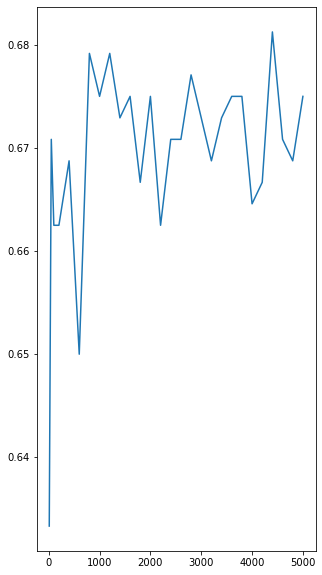

In [14]:
tree_step_df = pd.DataFrame(df)
pyplot.figure (figsize=(5, 10))
pyplot.plot(tree_step_df.i, tree_step_df.df_test)
pyplot.show()

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [15]:
cs(GC(), X, y, scoring='accuracy', cv=5).mean()


0.5672296238244513

In [43]:
cs(XGBS(), X, y, scoring='accuracy', cv=5).mean()

nan

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [35]:
params = {'learning_rate' : [0.01, 0.02, 0.1],
'n_estimators' : [1, 2, 3],
'max_depth' : range(1,5)}


In [36]:
GS = GridSearchCV(GC(), params, cv=3)
GS.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.02, 0.1],
                         'max_depth': range(1, 5), 'n_estimators': [1, 2, 3]})

In [37]:
GS.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 3}

In [44]:
acc(y_test, GS.predict(X_test))


0.5666666666666667

In [40]:
XS = GridSearchCV(XGBS(), params, cv=3)
XS.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [41]:
XS.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 3}

Вывод: xgboost работает быстрей

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [ ]:
cs(LGBMClassifier(), X, y, scoring='accuracy').mean()


In [ ]:
cs(CatBoostClassifier(), X, y, scoring='accuracy').mean()

Лучший результат у CatBoostClassifier

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [ ]:
par = {'learning_rate' : [0.01, 0.05, 0.1],
       'n_estimators' : [1, 2, 4, 8, 16, 32],
        'max_depth' : range(1,5,10)}

acc(y_test, GridSearchCV(LGBMClassifier(), par).fit(X_train, y_train).predict(X_test))


In [ ]:
acc(y_test, GridSearchCV(CatBoostClassifier(), par).fit(X_train, y_train).predict(X_test))

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью hyperopt . 
Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [103]:
par = {'learning_rate': hp.choice('x_learning_rate', [0.01, 0.05, 0.1]),
'n_estimators': hp.choice('x_n_estimators', [10, 100, 150]),
'max_depth': hp.choice('x_max_depth', [1, 5])}

In [106]:
def objective(params):
    clf = XGBS(**params)
    score = cs(clf, X, y, cv=3).mean()
    return -score

In [107]:
best_params = fmin(
  objective, 
  space = par, 
  algo = tpe.suggest, 
  max_evals = 20,
  trials = Trials())

100%|██████████| 20/20 [00:00<00:00, 26.28trial/s, best loss=?]


AllTrialsFailed: 

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [ ]:
date = [('GC', GC()),
        ('LGBM', LGBMClassifier()),
        ('XGBC', XGBS())]
date_stack = StackingClassifier(estimators=date, final_estimator=CatBoostClassifier())
date_stack.fit(X_train, y_train)

In [ ]:
acc(np.ravel(y_test, ), date_stack.predict(X_test))

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [ ]:
date = [('GC', GC(learning_rate=0.01, max_depth=2, n_estimators= 10)),
        ('LGBM', LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators= 20)),
        ('XGBC', XGBS(learning_rate=0.03, max_depth=4, n_estimators= 30))]
date_stack = StackingClassifier(estimators=date, final_estimator=CatBoostClassifier(learning_rate=0.01, max_depth=2, n_estimators= 20))
date_stack.fit(X_train, y_train)

In [ ]:
acc(np.ravel(y_test, ), date_stack.predict(X_test))

Лучшее качество показывает стекинг с параметрами.